<a href="https://colab.research.google.com/github/DuaEstwald/Modelos-Estelares-Simples/blob/master/TCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Alumna*: Elena Arjona Gávez

*Asignatura*: Técnicas Computacionales Básicas

*Profesor*: Francisco Kitaura

Máster en Astrofísica, Universidad de la Laguna.


# Degeneración de las curvas de rotación en la galaxia NGC2974

En este informe se usarán los datos de la curva de rotación de la galaxia NGC 2974 facilitados por Anne-Marie Weijmans, investigadora en la universidad de Leiden, utilizados en su artículo ***The shape of the dark matter halo in the early-type galaxy NGC 2974***.

La intención principal de este informe es analizar la degeneración de la curva de rotación de dicha galaxia mediante el *Metropolis-Hastings algorithm*.




### 1. Datos y modelos utilizados

Como ya es bien conocido, al observar las curvas de rotación en galaxias con disco, existe una discrepacia entre dichas observaciones y las predicciones teóricas que tendría esta galaxia si calculáramos la velocidad mediante la relación masa-luminosidad. Estudios relacionan esta discrepancia a una gran cantidad de materia oscura que envuelve la galaxia en un gran halo, Begemann et al. (1991).

Sin embargo, existe una degeneración entre la contribución disco-halo. Es decir, no existe una única solución que nos ajuste la curva de rotación observada con nuestros datos teóricos. 

Este trabajo pretende mostrar dicha degeneración para la galaxia NGC2974. Los distintos tipos de datos facilitados para este estudio han sido:

*   Velocidad de rotación de la galaxia, estos datos presentan unas barras de error de 10 km/s, que reflejan las distintas correcciones realizadas para trabajar con dichos datos.

*   Componente de velocidad causada por la masa estelar. Estos datos se han obtenido basados en el *MGE model*, con un valor de 2.34 M/L usado para dicho modelo.

*   Componente de velocidad causada por el gas neutro. 

Puesto que no es el objetivo del trabajo, no entraremos en más detalles sobre los datos. Una explicación más detallada de ellos se puede encontrar en el artículo mencionado anteriormente.


Finalmente, para modelizar la componente de materia oscura, aproximaremos el halo de materia oscura a una esfera pseudo-isotérmica, cuyo perfil de densidad viene dado por:

$$\rho(r) = \frac{\rho_0}{1+(r/r_c)^2}.\hspace{5mm}\mathrm{(1)}$$ 

donde $\rho_0$ y $r_c$ se refieren a la densidad y central y el radio de la esfera.

Dicho esto, es posible derivar analíticamente la curva de velocidad asociada a este modelo. Obtenemos entonces la expresión:

$$V^2_{c_{DM}} = 4\pi G\rho_0 r_c^2\left[1-\frac{r_c}{r}\arctan \left(\frac{r}{r_c}\right)\right].\hspace{5mm}\mathrm{(2)}$$


Una vez que tenemos las velocidades de las distintas componentes, el modelo resultante para la galaxia será la suma aditiva de estas:

$$V^2_{NGC2974}(r) = V^2_{c,halo} + V^2_{c,stars}+ V^2_{c,gas}.\hspace{5mm}\mathrm{(3)}$$

Es posible comprobar a simple vista que la componente de gas no jugará un gran papel en la curva de rotación, sin embargo, se tendrá en cuenta para un mayor sentido físico.

In [0]:
!pip install corner

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import corner

galaxy = np.loadtxt('rotcurve_NGC2974.dat') # Datos observados de la galaxia. 
#Primera columna: radio[arcsec], segunda columna: velocidad corregida por asymetric drift[km/s] con barras de error de 10km/s

sigma_galaxy = np.full(len(galaxy[:,1]),10.) # Construimos un array con la sigma de nuestros datos.

star0 = np.loadtxt('rotcurve_mge.dat') # Velocidad de rotacion de las estrellas, obtenidos a traves del modelo MGE con un valor utilizado de 2.34M/L para las poblaciones estelares.
# Primera columna: radio[arcsec], segunda columna: velocidad[km/s]

gas0 = np.loadtxt('vc_higas.dat') # Velocidad obtenida para el gas. 
# Primera columna: radio[arcsec], segunda columna: velocidad[km/s]

Dado que para el gas tenemos pocos datos, realizaremos un ajuste de segundo orden con el objetivo de extrapolar la curva a los datos observados. Análogamente para la componente estelar será necesario realizar una interpolación. 

In [0]:
# Extrapolacion para los datos de la componente de gas facilitados

def pol2(r,a0,a1,a2):
  return a0+a1*r+a2*r**2

popt,pcov = curve_fit(pol2,gas0[:,0],gas0[:,1])

v_gas = pol2(galaxy[:,0],popt[0],popt[1],popt[2])
gas = np.array([galaxy[:,0],v_gas]).T


# Interpolacion para los datos de la componente estelar facilitados

ff = interp1d(star0[:,0],star0[:,1])
v_star = ff(galaxy[:,0])
star = np.array([galaxy[:,0],v_star]).T


Finalmente, para realizar el modelo teórico del halo de materia oscura, utilizaremos como constantes $\rho_0 = 19\hspace{2mm}\mathrm{M}_\odot\mathrm{pc}^{-3}$ y $r_c = 0.23\hspace{2mm}\mathrm{kpc}$. Dichos valores se han tomado de Weijmans et. al (2008) y se usarán como parámetros iniciales en el estudio de la degeneración.

In [0]:
# Modelo teorico para el halo de materia oscura, eq.(2)

def DMhalo(r,rho_0, r_c):
  r = r*0.1*3.086e19  # from arcsec to kpc to m
  r_c = r_c*3.086e19  # from kpc to m
  Msol = 1.989e30 # kg
  rho_0 = rho_0*Msol/(3.086e16)**3
  G = 6.67408e-11 # Nm2/kg2
  Vc2 = 4*np.pi*G*rho_0*(r_c**2)*(1-(r_c/r)*np.arctan(r/r_c))
  Vc = np.sqrt(Vc2)
  return Vc*1e-3 #km/s


r_c = 0.23 #kpc
rho_0 = 19.0 #Msol/pc3
v_halo = DMhalo(galaxy[:,0],rho_0,r_c)
halo = np.array([galaxy[:,0],v_halo]).T

Una vez que tenemos los datos para las tres componentes y para la galaxia, veamos si nuestro modelo inicial se ajusta adecuadamente a la eq. (3) con los valores impuestos de $\rho_0$ y $r_c$.

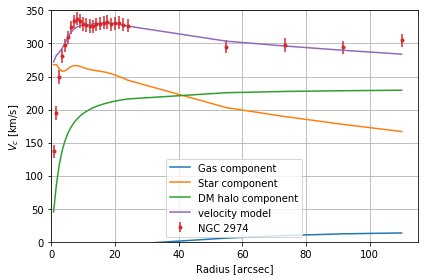

In [68]:
# Modelo de la curva de rotación segun la eq.(3)

def rotcurve(r,param_init):
  # Con el objetivo de realizar un estudio de la contribucion de las componentes en estrella y en gas
  # se han añadido las constantes b1 y b2, que serán 1 inicialmente segun la eq. (3).
  a0 = popt[0]
  a1 = popt[1]
  a2 = popt[2]
  
  rho0 = param_init[0]
  rc = param_init[1]
  b1 = param_init[2]
  b2 = param_init[3]
  return np.sqrt(DMhalo(r,param_init[0],param_init[1])**2+b1*ff(r)**2+b2*pol2(r,a0,a1,a2)**2)


# Representacion del modelo teorico frente al observado, junto con los modelos de cada componente

fig0 = plt.figure()
plt.plot(gas[:,0],gas[:,1],label = 'Gas component')
plt.plot(star[:,0],star[:,1],label='Star component')
plt.plot(halo[:,0],halo[:,1],label = 'DM halo component')
plt.errorbar(galaxy[:,0],galaxy[:,1],yerr=sigma_galaxy,fmt='.',label='NGC 2974')
plt.plot(galaxy[:,0],rotcurve(galaxy[:,0],[19.0,0.23,1.0,1.0]), label = 'velocity model')
plt.grid()
plt.xlabel('Radius [arcsec]')
plt.ylabel(r'$V_c$ [km/s]')
plt.legend()
plt.xlim(0,115)
plt.ylim(0,350)
plt.tight_layout()
plt.savefig('model0.png')


### 2. The Metropolis-Hastings algorithm

Tras el ajuste, realizado con las constantes que Weijmann et. al(2008) utiliza en su trabajo, podemos proceder a realizar un análisis de los parámetros de mejor ajuste. Realizaremos esto implementando el algoritmo MH, el cual se basa en una cadena de Markov, MCMC. 

Para ello, tomaremos como parámetros iniciales, $\theta^i$, los valores ya utilizados para el primer ajuste. Tras esto, iremos sampleando el espacio de parámetros aceptando aquellos que obtengan una *likelihood* más cercana a 0. Los que no cumplan esta condición anterior, tendrán una probabilidad $\alpha$ de ser aceptados.

La *likelihood* de estos parámetros viene dada por una distribución gaussiana tal que:

$$\mathscr{L} \sim \prod_{i=1}^{N}\exp\left(\frac{data-f(data,\theta^i)^2}{2\sigma^2}\right)\hspace{5mm}(4).$$

donde N es el número de datos con el que estamos trabajando, $\theta^{i}$ son los parámetros de nuestro ajuste y $\sigma$ el error en la medida. 

Para mayor facilidad, se trabajará con el logaritmo de la *likelihood*.

Impondremos una probabilidad de aceptar o denegar estos nuevos parámetros, que será:

$$\frac{\mathscr{L}^{\theta^{i}_{new}}}{\mathscr{L}^{\theta^{i}_{old}}} \geq a $$

donde a es un valor comprendido entre 0 y 1.

Por otro lado, con el objetivo de darle un sentido físico al análisis, impondremos un *prior*, es decir, obligaremos a que los nuevos parámetros cumplan una serie de condiciones: 

*   $0.5 < b1 < 1.5$
*   $0.5 < b2 < 1.5$

Más concretamente, impondremos a la contribución de las estrellas y del gas un rango para evitar encontrar unos parámetros desorbitados.



In [0]:
# Definimos entonces nuestra likelihood

def log_likelihood(vobs,robs,param_init,sigma):
  return np.sum(-((vobs-rotcurve(robs,param_init))**2.)/(2.*sigma**2.))


# Implementamos el MH-algorithm

def metropolis_hastings(vobs,robs,param_init,sigma,iterations, seed, prior):
  random.seed(seed)
  param = [param_init]
  loglikeli = [log_likelihood(vobs,robs,param[-1],sigma)]

  for i in range(iterations):
    param_new = []
    for p in param[-1]:
      param_new.append(np.abs(p+p*random.uniform(-0.005,0.005)))
    if prior:
      if (param_new[2]<0.5)|(param_new[2]>1.5): #Imponemos el prior
        continue
      if (param_new[3]<0.5)|(param_new[3]>1.5):
        continue
    loglikenew = log_likelihood(vobs,robs,param_new,sigma)
    if np.exp(loglikenew-loglikeli[-1]) >= random.random(): # Aceptamos o rechazamos los nuevos parametros
      param.append(param_new)
      loglikeli.append(loglikenew)

  return param,loglikeli

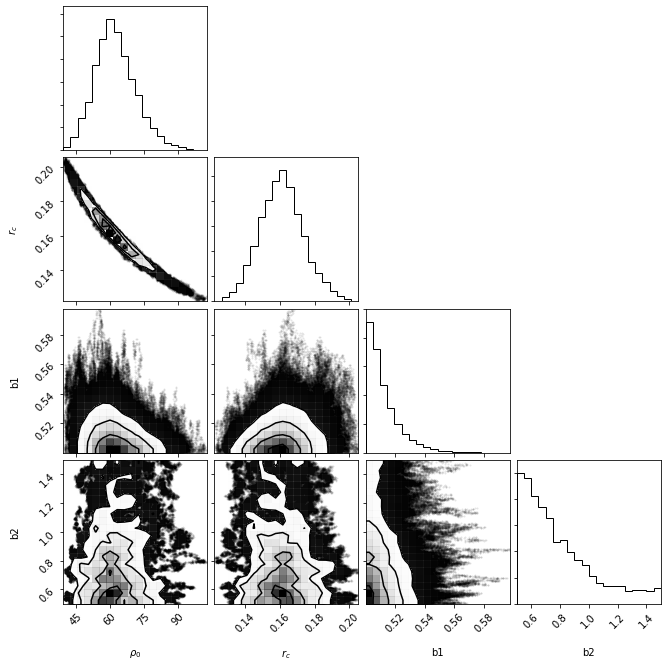

In [132]:
p0, lh0 = metropolis_hastings(galaxy[:,1],galaxy[:,0],[19.0,0.23,1.,1.], sigma_galaxy, 1000000, 1997, prior = True)
param = p0[int(len(p0)*0.1):]
fig1 = corner.corner(param, labels=[r'$\rho_0$',r'$r_c$','b1','b2'])

Podemos comprobar como los parámetros relacionados con la contribución de las estrellas y el gas tienden a un valor menor que el impuesto. Por tanto, veamos qué ocurriría si utilizaramos el algoritmo sin *prior*.

In [130]:
pnew, lh = metropolis_hastings(galaxy[:,1],galaxy[:,0],[19.0,0.23,1.,1.], sigma_galaxy, 1000000, 1997, prior = False)
p = pnew[int(len(pnew)*0.1):] # Descartamos el 10% inicial de la cadena para asegurarnos de que todos los parámetros convergen.
print(len(p)/1000000) # acceptance [ratio] 
pp = np.array(p)

0.774666


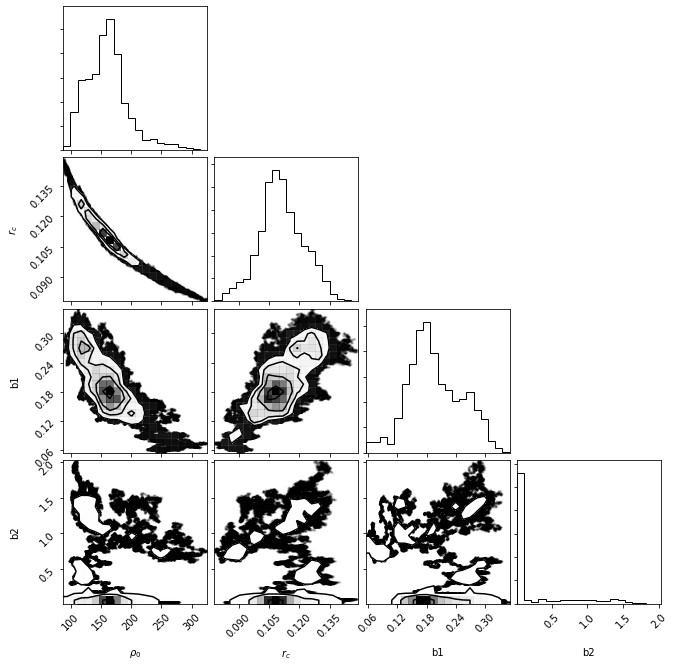

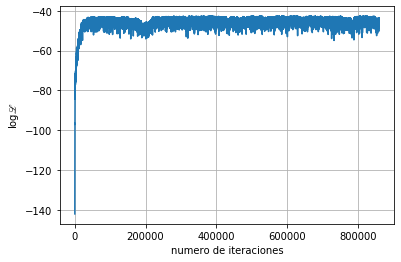

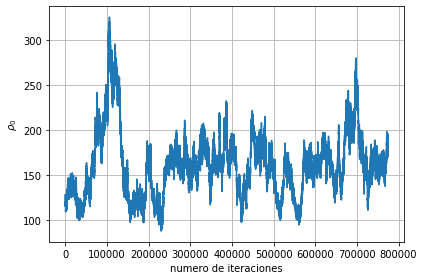

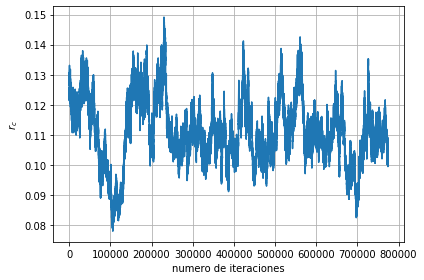

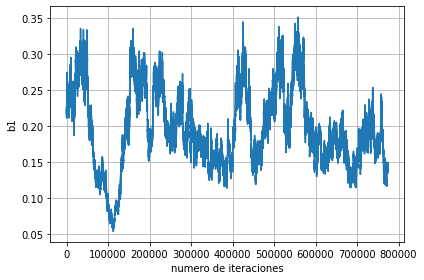

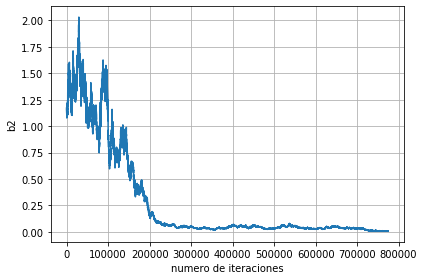

In [131]:
# Procedemos a representar los resultados obtenidos
fig2 = corner.corner(p,labels=[r'$\rho_0$',r'$r_c$','b1','b2'])
plt.savefig('correlation.png')

fig3 = plt.figure()
plt.plot(lh)
plt.grid()
plt.xlabel('numero de iteraciones')
plt.ylabel(r'$\log \mathscr{L}$')
plt.savefig('loglik.png')

fig4 = plt.figure()
plt.plot(pp[:,0])
plt.ylabel(r'$\rho_0$')
plt.xlabel('numero de iteraciones')
plt.grid()
plt.tight_layout()
fig5 = plt.figure()
plt.plot(pp[:,1])
plt.ylabel(r'$r_c$')
plt.xlabel('numero de iteraciones')
plt.grid()
plt.tight_layout()
fig6 = plt.figure()
plt.plot(pp[:,2])
plt.ylabel('b1')
plt.xlabel('numero de iteraciones')
plt.grid()
plt.tight_layout()
fig7 = plt.figure()
plt.plot(pp[:,3])
plt.ylabel('b2')
plt.xlabel('numero de iteraciones')
plt.grid()
plt.tight_layout()



### 3. Discusión de resultados

Podemos ver como, claramente, la densidad central del halo está altamente degenerada con respecto al radio del mismo. Comprobamos como el radio crece a medida que la densidad central disminuye, manteniendo prácticamente constante el valor de la *likelihood*. Cualquiera de estos parámetros implicaría en la medida un mejor ajuste que el propuesto inicialmente. Por otro lado, como ya comentamos al inicio, la componente de gas en la galaxia es tan despreciable que la constante de ponderación del gas converge a cero rápidamente.

Cabe destacar que en la primera figura se ha descartado el 10% inicial de los parámetros obtenidos para asegurarnos de analizar sólo los valores en los que la *likelihood* ya ha convergido a un valor mínimo.

En la siguiente figura se muestra cómo, al inicio de la cadena, la *likelihood* se va haciendo mínima tras cada iteración hasta llegar a un valor límite. Este valor viene marcado por el error, $\sigma$, de nuestros datos.

Procedemos ahora a representar de nuevo el modelo teórico con respecto a los parámetros relacionados con la *likelihood* obtenida más cercana a 0.

[145.65744046692058, 0.11380909114951329, 0.22653203561012236, 0.12731265912818499]


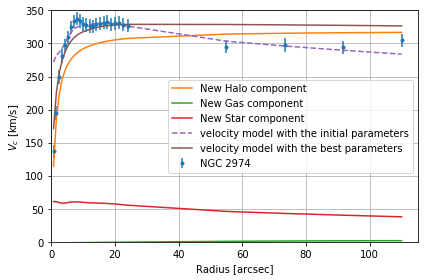

In [113]:
best_parameters = p0[np.where(lh0 == np.max(lh0))[0][0]]
print(best_parameters)

fig3 = plt.figure()
plt.errorbar(galaxy[:,0],galaxy[:,1],yerr=sigma_galaxy,fmt='.',label='NGC 2974')
plt.plot(halo[:,0],DMhalo(halo[:,0],best_parameters[0],best_parameters[1]),label='New Halo component')
plt.plot(gas[:,0],best_parameters[3]*gas[:,1],label = 'New Gas component')
plt.plot(star[:,0],best_parameters[2]*star[:,1],label='New Star component')
plt.plot(galaxy[:,0],rotcurve(galaxy[:,0],[19.0,0.23,1.0,1.0]),'--', label = 'velocity model with the initial parameters')
plt.plot(galaxy[:,0],rotcurve(galaxy[:,0],best_parameters), label = 'velocity model with the best parameters')
plt.xlabel('Radius [arcsec]')
plt.ylabel(r'$V_c$ [km/s]')
plt.grid()
plt.legend()
plt.xlim(0,115)
plt.ylim(0,350)
plt.tight_layout()
plt.savefig('modelnew.png')



Podemos ver como, aunque tengamos un ajuste con una *likelihood* mucho más correcta, el peso que el algoritmo le da al halo de materia oscura está totalmente desmesurado en base la componente en estrella y en gas, obteniendo una densidad central y un radio de $\rho_0 \sim 146\hspace{2mm}\mathrm{M}_\odot\mathrm{pc}^{-3}$ y $r_c\sim 0.114\hspace{2mm}\mathrm{kpc}$. Con esto podemos concluir que, en estos casos, un sentido físico es importante a tener en cuenta para escoger unos parámetros adecuados a nuestros modelos.


### Observaciones

Por último, es posible realizar varias cadenas de Markov con distintos parámetros iniciales para comprobar que siempre convergen a la misma solución. 

Variar el número de iteraciones o el incremento en los nuevos parámetros con respecto al anterior provocará también un cambio al muestrear el espacio de parámetros. Es necesario escoger en la medida de lo posible unos valores adecuados en relación a nuestro problema. 